<a href="https://colab.research.google.com/github/zulylapa/GEOS_518_LAPA/blob/main/mod03_1D_Diffusion_Assignment_Lapa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 03: Assignment for 1-D Diffusion Problem - Thawing Permafrost
## By Zuly Lapa

### 1. Introduction and Background

In this notebook you are going to investigate the impact of three climate change scenarios on our previously developed model of the vertical distribution of temperature in a permafrost soil.


Again, the equation for 1-dimensional heat diffusion into a soil is presented below:
$$
\rho_s \cdot C_s \cdot \frac{\partial T_s}{\partial t} = \frac{\partial T_s}{\partial z}\left(k_s \cdot \frac{\partial T_s}{\partial z}\right)
$$

where $\rho_s$ (kg/m^3) is the bulk density of the soil, $C_s$ (J/(kg K)) is the heat capacity of the soil, $k_s$ (W/(m K)) is the thermal conductivity of the soil, $T_s$ is the temperature of the soil at some time $t$ and depth in the soil $z$. For the sake of simplicity, we're going to assume that the thermal conductivity is constant. This assumption is not strictly true, as $k_s$ changes with the amount and phase (frozen or liquid) of water in the soil. But it makes the math much simpler and is good starting point for a toy model. Under this assumption we can simplify the above equation to,

$$
\rho_s \cdot C_s \cdot \frac{\partial T_s}{\partial t} = k_s \frac{\partial T_s^2}{\partial^2 z}
$$

Going further, if we also assume that the bulk density ($rho_s$) and heat capacity ($C_s$) are constant, then we can combine them with the thermal conductivity and reduce them to a single parameter that is often referred to as the _thermal diffusivity_ ($D_s$) and has dimensions of m^2/s,

$$
D_s = \frac{k_s}{\rho_s \cdot C_s}
$$

Substituting into the above, we obtain the following governing equation that our model will solve,

$$
\frac{\partial T_s}{\partial t} = D_s \frac{\partial T_s^2}{\partial^2 z}
$$

Your __top boundary condition__, we will assume sinusoidal forcing of air temperature superimposed on a linear trend in mean annual temperatures at the surface, with a period of one year. In this notebook we will explore three scenarios. Scenario 1 is a linear increase in mean annual temperature at a rate that results in 1.5 °C of warming by 2100. Scenario 2 is a linear increase in mean annual temperature at a rate that results in 3.0 °C of warming by 2100. Scenario 3 is a linear increase in mean annual temperature at a rate that results in 4.5 °C of warming by 2100. We will start all simulations in 2020.

Your __bottom boundary condition__, we will assume a constant temperature at the initial mean annual air temperature.

Yur __initial condition__ will be a constant temperature (isothermal) at the mean annual air temperature. If interested you can copy this notebook and modify these values.

### 2. Initial Setup

Below, we set the values for our spatial domain, simulation period, soil properties, and boundary conditions.

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Soil column properties
zs = 500.0 # Depth of soil [cm]
dz = 15.0   # Numerical model layer thickness [cm]

# Soil properties (obtained from https://doi.org/10.1029/2017JF004535)
Cs = 635.0 # Heat capacity of soil/permafrost [J/(kg K)]
ks = 0.25  # Thermal conductivity of soil/permafrost [W/(m K)]
rhos = 920.0 # Bulk density of permafrost [kg/m^3]

dt = 0.25 # Time step [day]

#### 2.1 Load and Plot the Air Temperature Trends

In [6]:
data = np.loadtxt('PermafrostTemperatureScenarios.csv', delimiter=',', skiprows=1)

t_year = data[:,0] # First column of the table
T_15 = data[:,1]   # Second column of the table
T_30 = data[:,2]   # Third column of the table
T_45 = data[:,3]   # Fourth column of the table

# print(data) # Check the data is correct

Text(0, 0.5, 'Annual average air temperature [°C]')

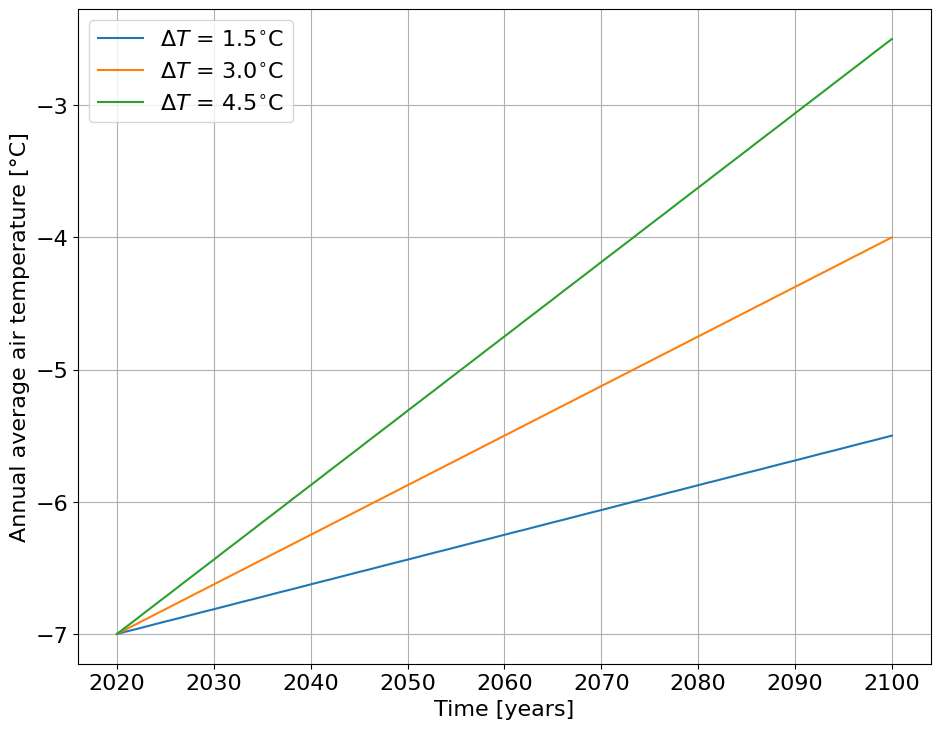

In [7]:
## First off, let's change the font size for all of our plots to be more legible
plt.rcParams.update({'font.size': 16})

plt.figure(figsize=(11.0,8.5))
plt.plot(t_year,T_15,label='$\Delta T$ = 1.5${}^{\circ}$C')
plt.plot(t_year,T_30,label='$\Delta T$ = 3.0${}^{\circ}$C')
plt.plot(t_year,T_45,label='$\Delta T$ = 4.5${}^{\circ}$C')
plt.legend(loc='upper left')
plt.grid()
plt.xlabel('Time [years]')
plt.ylabel('Annual average air temperature [°C]')

#### 2.2 Setup the Simulation Time Period

In [11]:
# Time properties of simulation
t0 = t_year[0]  # First year in the table
tf = t_year[-1] # Last year in the table

t = np.arange(t0,tf+(dt/365),(dt/365))
Nt = t.size
print('The number of time steps: Nt = ',str(Nt))

# Confirmation that the first and last year in the table is pulled in correctly
# print(t0)
# print(tf)


The number of time steps: Nt =  116801


### 3. Setup Boundary Conditions

In [12]:
# Boundary conditions
Ttopamp = 35.0
Tbottom = -7.0

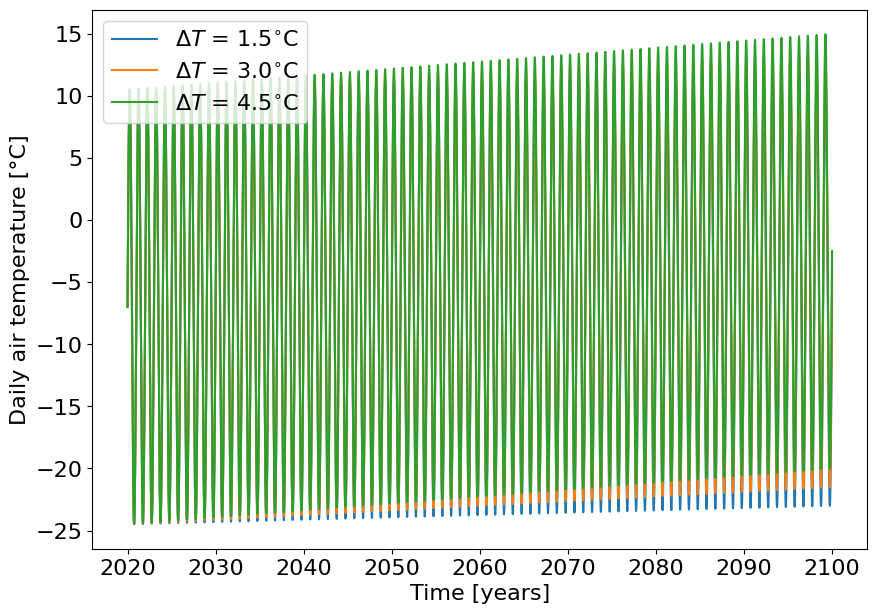

In [13]:
# Perform interpolation
# np.interp estimates T_15 (or 30 or 45) at the times specified by the time array, based the known time year
Ttop_15 = np.interp(t, t_year, T_15) + (Ttopamp/2.0)*np.sin((2.0*np.pi)*t) # taking the annual sine wave and creating temperature pattern or fluctuations
Ttop_30 = np.interp(t, t_year, T_30) + (Ttopamp/2.0)*np.sin((2.0*np.pi)*t)
Ttop_45 = np.interp(t, t_year, T_45) + (Ttopamp/2.0)*np.sin((2.0*np.pi)*t)

# Plot figure
plt.figure(figsize=(10.0,7.0))
plt.plot(t, Ttop_15, label='$\Delta T$ = 1.5${}^{\circ}$C')
plt.plot(t, Ttop_30, label='$\Delta T$ = 3.0${}^{\circ}$C')
plt.plot(t, Ttop_45, label='$\Delta T$ = 4.5${}^{\circ}$C')
plt.xlabel('Time [years]')
plt.ylabel('Daily air temperature [°C]')
plt.legend(loc='upper left')
plt.show()

### 4. Setup Spatial Domain

In [14]:
# np.arange starts at half of the layer thickness and ends at the depth of soil. The spacing between is dictated by the thickenss layer.
z = np.arange(dz/2,zs,dz)
Nz = z.size
print('Here are the locations of our cells: z = \n' + str(z))
print('The number of cells is: Nz = ',str(Nz))

Here are the locations of our cells: z = 
[  7.5  22.5  37.5  52.5  67.5  82.5  97.5 112.5 127.5 142.5 157.5 172.5
 187.5 202.5 217.5 232.5 247.5 262.5 277.5 292.5 307.5 322.5 337.5 352.5
 367.5 382.5 397.5 412.5 427.5 442.5 457.5 472.5 487.5]
The number of cells is: Nz =  33


### 5. Setup Initial Condition

In [53]:
Ts0_15 = Tbottom*np.ones((Nz,1))
Ts0_30 = Tbottom*np.ones((Nz,1))
Ts0_45 = Tbottom*np.ones((Nz,1))
# print(Ts0)

### 6. Calculate $D$, $\mathbf{A}$, and $\mathbf{B}$ Matrices for Implicit or Crank-Nicolson Method

(copied over from the example notebook) In this notebook, we use the Crank-Nicolson scheme, which essentially combines both the backward Euler implicit and forward Euler explicit methods. As with the explicit and implicit cases, we divide our soil column into layers of equal thickness, specify boundary conditions at the top and bottom of our soil, as well as an initial condition and simulate the evolution of soil temperature over a 10 year period. We again skip the math of applying this method and go right to the finite difference solution, solveing for the soil temperature at the $(i+1)$th time in ___all soil layers simultaneously___,

$$
\mathbf{T}^{i+1} = \mathbf{A}^{-1} \cdot \mathbf{B} \cdot \mathbf{T}^i
$$

where the matrix $\mathbf{A}$ combines the centered space finite difference operator, and soil diffusivity to develop the backward Euler part of the solution and is defined as follows

$$
\mathbf{A} = \left(D_s\frac{\Delta t}{2 \Delta z^2}\right)\left[\mathbf{I} - \mathbf{\Delta}_2\right]
$$

where $\mathbf{I}$ is the identity matrix,

$$
\mathbf{I} =
\begin{bmatrix}
    1 & 0 & 0 & \dots & 0 \\
    0 & 1 & 0 & \dots & 0 \\
    \vdots & \vdots & \ddots & \vdots & \vdots \\
    0 & \dots & \dots & 1 & 0 \\
    0 & \dots & \dots & 0 & 1    
\end{bmatrix}
$$


and $\mathbf{\Delta_2}$ is the centered space finite difference operator, given by,

$$
\mathbf{\Delta}_2 =
\begin{bmatrix}
    -2 & 1 & 0 & \dots & 0 \\
    1 & -2 & 1 & \dots & 0 \\
    \vdots & \vdots & \ddots & \vdots & \vdots \\
    0 & \dots & 1 & -2 & 1 \\
    0 & \dots & \dots & 1 & -2
\end{bmatrix}
$$

Similarly the matrix $\mathbf{B}$ combines the centered space finite difference operator, and soil diffusivity, to capture the forward Euler part of the solution and is defined as,

$$
\mathbf{B} = \left(D_s\frac{\Delta t}{2 \Delta z^2}\right)\left[\mathbf{I} + \mathbf{\Delta}_2\right]
$$

In [54]:
# Calculate soil diffusivity (D)

Ds = ks / (rhos * Cs)
print('Soil diffusivity = '+str(Ds)+' m^2/s')

# Convert alpha to units consistent with domain [cm^2/day]
Ds = Ds*(100.0**2)*(24.0*3600.0)
print('Soil diffusivity = '+str(Ds)+' cm^2/day')

alpha = Ds*dt/(dz**2)
print('Diffusion number '+str(alpha))

# Calculate A matrix
A = np.diag((1 + 2.0*alpha)*np.ones((Nz))) + \
    np.diag(-alpha*np.ones((Nz-1)),1) + \
    np.diag(-alpha*np.ones((Nz-1)),-1)

A[0,:] = np.hstack((1.0,np.zeros((Nz-1))))
A[-1,:] = np.hstack((np.zeros((Nz-1)),1.0))

print(A)

# Calculate B matrix
B = np.diag((1 - 2.0*alpha)*np.ones((Nz))) + \
    np.diag(alpha*np.ones((Nz-1)),1) + \
    np.diag(alpha*np.ones((Nz-1)),-1)

B[0,:] = np.hstack((1.0,np.zeros((Nz-1))))
B[-1,:] = np.hstack((np.zeros((Nz-1)),1.0))

print(B)

Soil diffusivity = 4.279356384799726e-07 m^2/s
Soil diffusivity = 369.7363916466963 cm^2/day
Diffusion number 0.41081821294077364
[[ 1.          0.          0.         ...  0.          0.
   0.        ]
 [-0.41081821  1.82163643 -0.41081821 ...  0.          0.
   0.        ]
 [ 0.         -0.41081821  1.82163643 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  1.82163643 -0.41081821
   0.        ]
 [ 0.          0.          0.         ... -0.41081821  1.82163643
  -0.41081821]
 [ 0.          0.          0.         ...  0.          0.
   1.        ]]
[[1.         0.         0.         ... 0.         0.         0.        ]
 [0.41081821 0.17836357 0.41081821 ... 0.         0.         0.        ]
 [0.         0.41081821 0.17836357 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.17836357 0.41081821 0.        ]
 [0.         0.         0.         ... 0.41081821 0.17836357 0.41081821]
 [0.         0.         0.         ... 0

### 7. Preallocate Storage for Soil Temperatures

In [55]:
Ts_15 = np.zeros((Nz,Nt))
Ts_30 = np.zeros((Nz,Nt))
Ts_45 = np.zeros((Nz,Nt))


### 8. Apply Solution And Compute Temperatures

In [71]:
for i in np.arange(Nt):
    if(i==0):
        Tsi_15 = Ts0_15
        Tsi_30 = Ts0_30
        Tsi_45 = Ts0_45
    else:
        Tsi_15 = Ts_15[:,i-1]
        Tsi_15[0] = Ttop_15[i]
        Tsi_15[-1] = Tbottom

        Tsi_30 = Ts_30[:,i-1]
        Tsi_30[0] = Ttop_30[i]
        Tsi_30[-1] = Tbottom

        Tsi_45 = Ts_45[:,i-1]
        Tsi_45[0] = Ttop_45[i]
        Tsi_45[-1] = Tbottom

    Tsip1 = np.matmul(np.matmul(np.linalg.pinv(A),B), Tsi_15)
    Tsip2 = np.matmul(np.matmul(np.linalg.pinv(A),B), Tsi_30)
    Tsip3 = np.matmul(np.matmul(np.linalg.pinv(A),B), Tsi_45)

    Ts_15[:,i] = np.squeeze(Tsip1)
    Ts_30[:,i] = np.squeeze(Tsip2)
    Ts_45[:,i] = np.squeeze(Tsip3)


In [70]:
#print (Ts_15[:,i])
#print (Ts_30[:,i])
#print (Ts_45[:,i])

### 9. Plot Results, Analyze, and Interpret

Create plots of the following:

1. A plot of 3 x 2 subplots of the vertical temperature distribution with time. Each row should correspond to each of the 3 climate change scenarios wiht the top row being the $\Delta T$ = 1.5${}^{\circ}$C, the middle being $\Delta T$ = 3.0${}^{\circ}$C, and the bottom row being $\Delta T$ = 4.5${}^{\circ}$C. The left column should correspond to the ___first___ 10 years of simulation, and the right column the ___last___ 10 years of simulation.


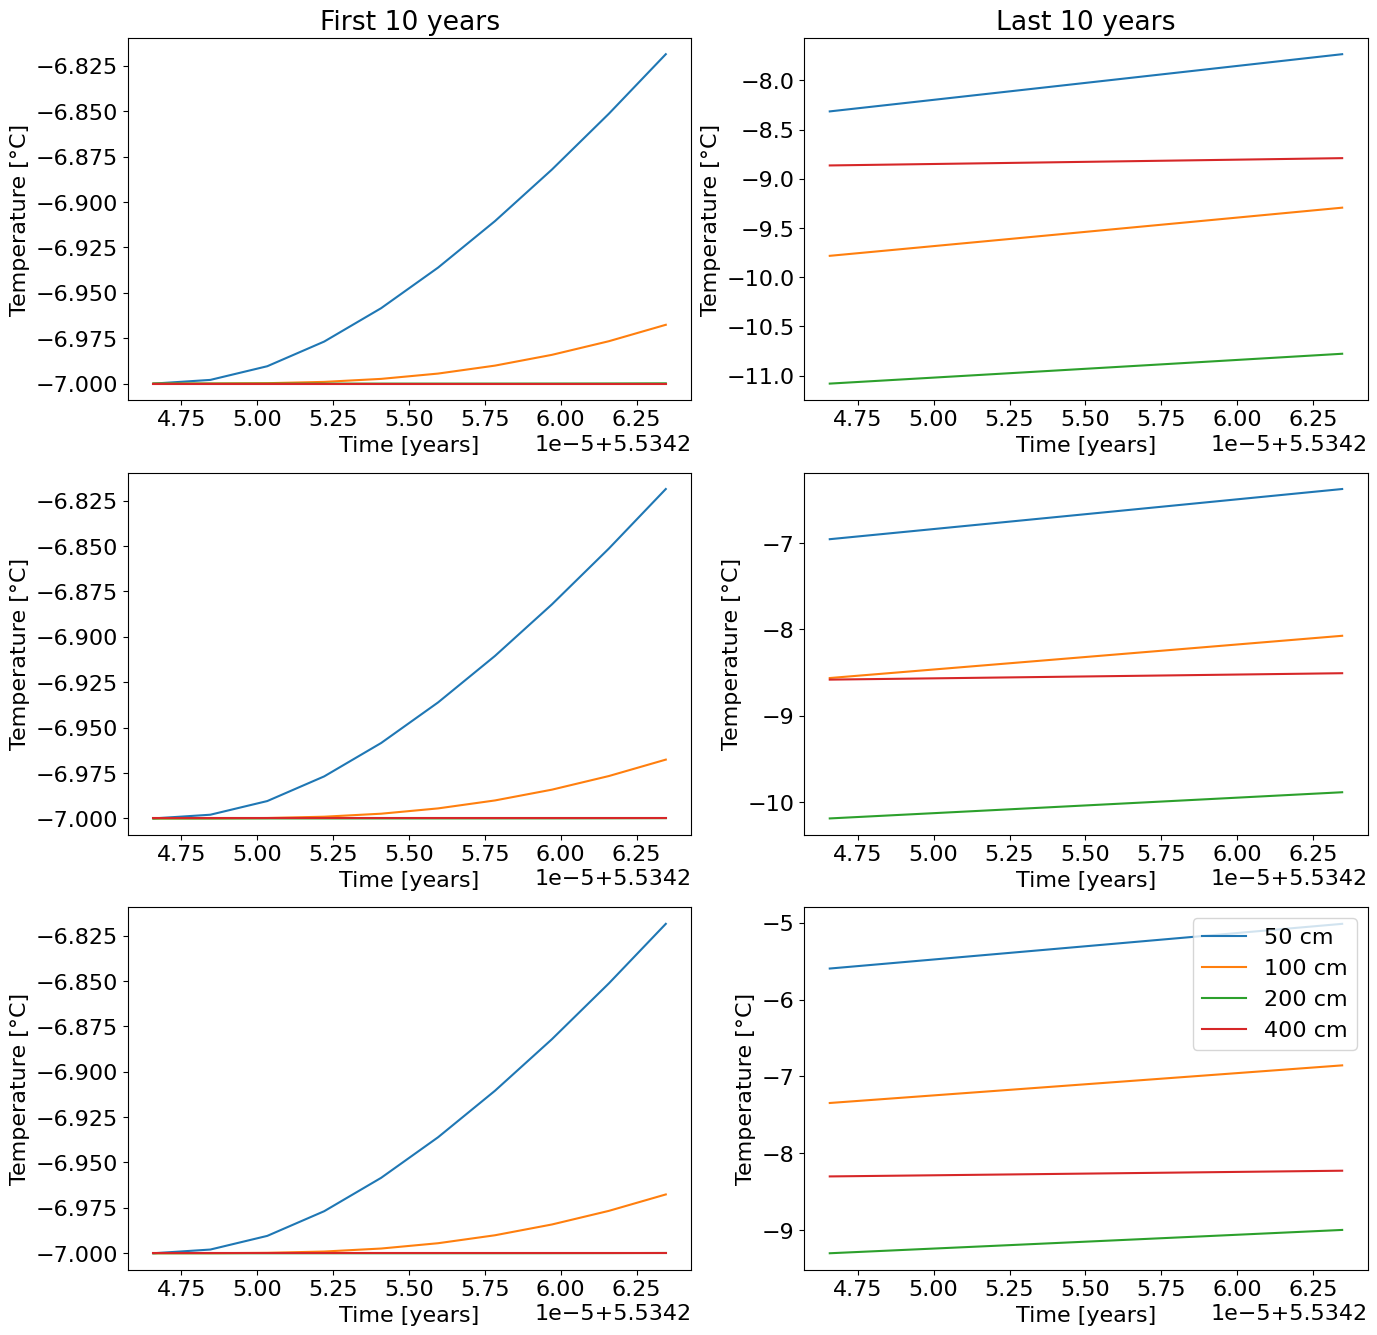

In [84]:
plt.figure(figsize=(16,16))
plt.rcParams.update({'font.size': 16})

iz50 = (np.absolute(z-50.0)).argmin()
iz100 = (np.absolute(z-100.0)).argmin()
iz200 = (np.absolute(z-200.0)).argmin()
iz400 = (np.absolute(z-400.0)).argmin()

# plot climate change scenario 1 (1.5 deg C) for the first 10 years
plt.subplot(3,2,1)
plt.plot(t[:10]/365,Ts_15[iz50,:10].T, label = '50 cm')
plt.plot(t[:10]/365,Ts_15[iz100,:10].T, label = '100 cm')
plt.plot(t[:10]/365,Ts_15[iz200,:10].T, label = '200 cm')
plt.plot(t[:10]/365,Ts_15[iz400,:10].T, label = '400 cm')
plt.title('First 10 years')
plt.xlabel('Time [years]')
plt.ylabel('Temperature [°C]')

# plot climate change scenario 1 (1.5 deg C) for the last 10 years
plt.subplot(3,2,2)
plt.plot(t[:10]/365,Ts_15[iz50, -10:].T, label = '50 cm')
plt.plot(t[:10]/365,Ts_15[iz100, -10:].T, label = '100 cm')
plt.plot(t[:10]/365,Ts_15[iz200, -10:].T, label = '200 cm')
plt.plot(t[:10]/365,Ts_15[iz400, -10:].T, label = '400 cm')
plt.title('Last 10 years')
plt.xlabel('Time [years]')
plt.ylabel('Temperature [°C]')

# plot climate change scenario 2 (3.0 deg C) for the first 10 years
plt.subplot(3,2,3)
plt.plot(t[:10]/365,Ts_30[iz50, :10].T, label = '50 cm')
plt.plot(t[:10]/365,Ts_30[iz100, :10].T, label = '100 cm')
plt.plot(t[:10]/365,Ts_30[iz200, :10].T, label = '200 cm')
plt.plot(t[:10]/365,Ts_30[iz400, :10].T, label = '400 cm')
plt.xlabel('Time [years]')
plt.ylabel('Temperature [°C]')

# plot climate change scenario 2 (3.0 deg C) for the last 10 years
plt.subplot(3,2,4)
plt.plot(t[:10]/365,Ts_30[iz50, -10:].T, label = '50 cm')
plt.plot(t[:10]/365,Ts_30[iz100, -10:].T, label = '100 cm')
plt.plot(t[:10]/365,Ts_30[iz200, -10:].T, label = '200 cm')
plt.plot(t[:10]/365,Ts_30[iz400, -10:].T, label = '400 cm')
plt.xlabel('Time [years]')
plt.ylabel('Temperature [°C]')

# plot climate change scenario 3 (4.5 deg C) for the first 10 years
plt.subplot(3,2,5)
plt.plot(t[:10]/365,Ts_45[iz50, :10].T, label = '50 cm')
plt.plot(t[:10]/365,Ts_45[iz100, :10].T, label = '100 cm')
plt.plot(t[:10]/365,Ts_45[iz200, :10].T, label = '200 cm')
plt.plot(t[:10]/365,Ts_45[iz400, :10].T, label = '400 cm')
plt.xlabel('Time [years]')
plt.ylabel('Temperature [°C]')

# plot climate change scenario 3 (4.5 deg C) for the last 10 years
plt.subplot(3,2,6)
plt.plot(t[:10]/365,Ts_45[iz50, -10:].T, label = '50 cm')
plt.plot(t[:10]/365,Ts_45[iz100, -10:].T, label = '100 cm')
plt.plot(t[:10]/365,Ts_45[iz200, -10:].T, label = '200 cm')
plt.plot(t[:10]/365,Ts_45[iz400, -10:].T, label = '400 cm')
plt.xlabel('Time [years]')
plt.ylabel('Temperature [°C]')
plt.legend(loc = 'upper right')
plt.show()


2. A plot of 2 x 2 subplots of the temperature at four different levels. One subplot of temperature versus time for all three scenarios at a depth of 50 cm, the second subplot the same information at 100 cm, the third subplot the same information at 200 cm, and the fourth subplot the same information at 400 cm.


Text(0, 0.5, 'Temperature [°C]')

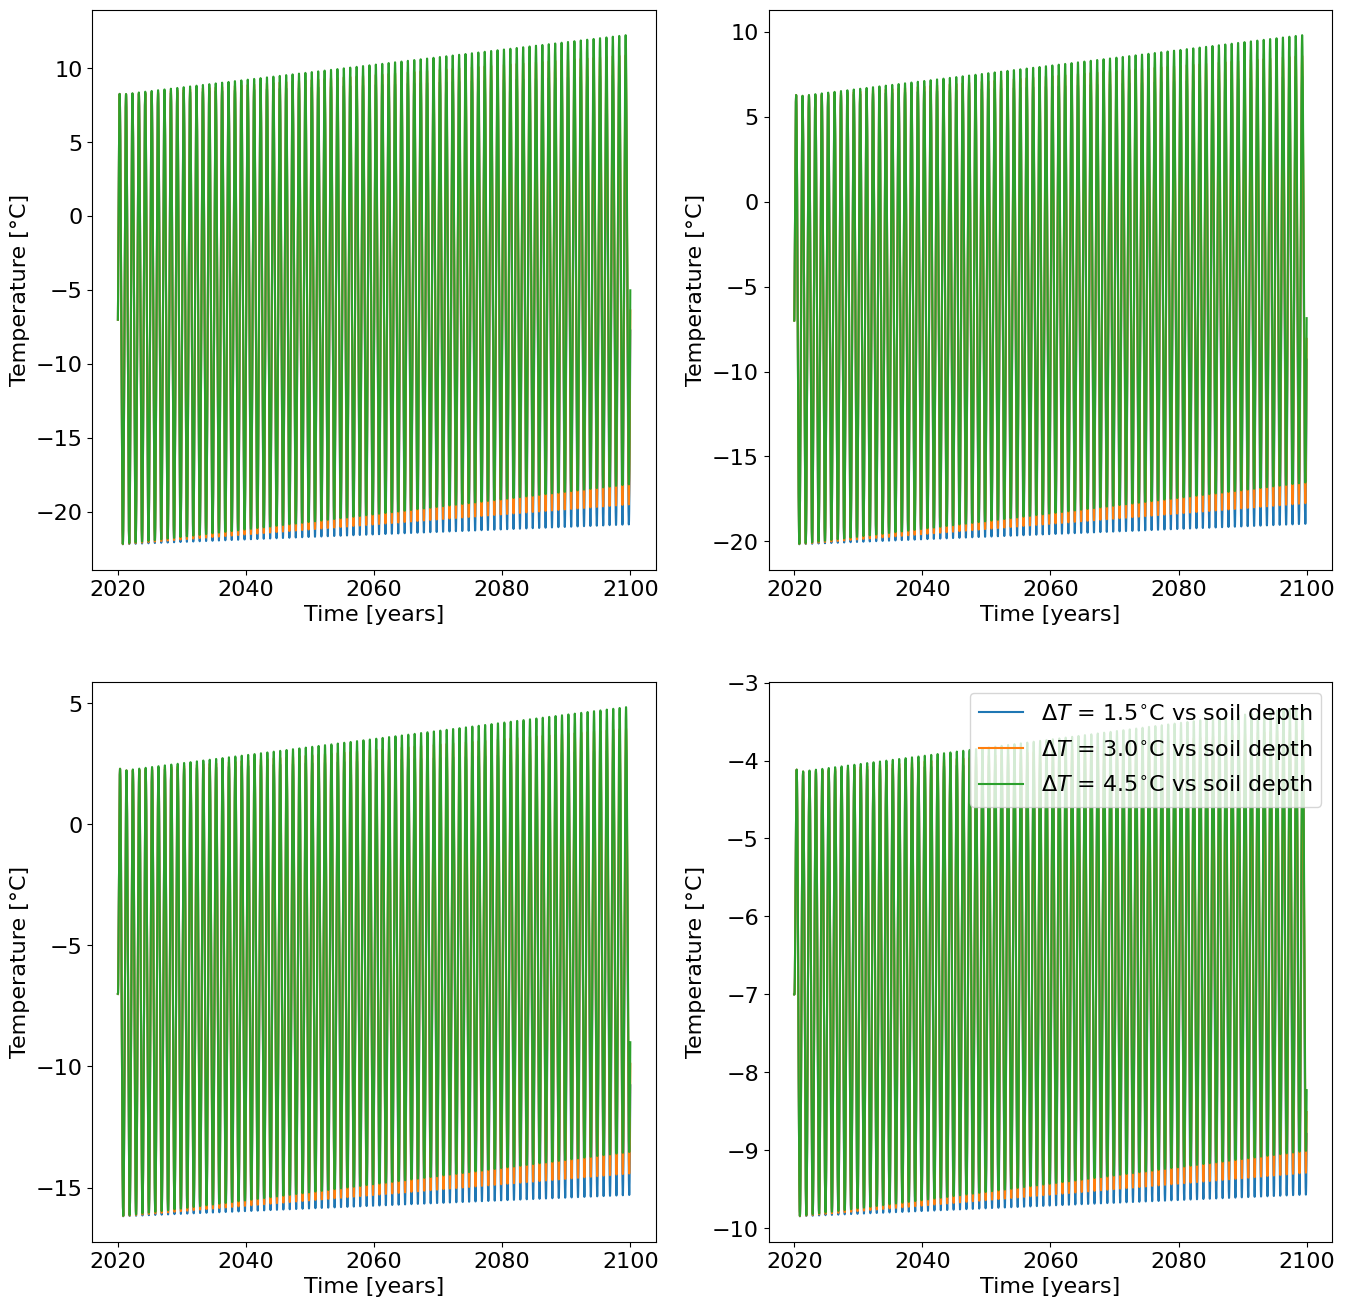

In [95]:
plt.figure(figsize=(16,16))
plt.rcParams.update({'font.size': 16})

# Based on the question, I assumed the plot was 2D, but I believe, the graph could have been a mesh grid as the exammple, which is shown below

# plot temperature vs time at a depth of 50 cm
plt.subplot(2,2,1)
plt.plot(t, Ts_15[iz50].T, label = '$\Delta T$ = 1.5${}^{\circ}$C vs soil depth')
plt.plot(t, Ts_30[iz50].T, label = '$\Delta T$ = 3.0${}^{\circ}$C vs soil depth')
plt.plot(t, Ts_45[iz50].T, label = '$\Delta T$ = 4.5${}^{\circ}$C vs soil depth')
plt.xlabel('Time [years]')
plt.ylabel('Temperature [°C]')

# plot temperature vs time at a depth of 100 cm
plt.subplot(2,2,2)
plt.plot(t,Ts_15[iz100].T, label = '$\Delta T$ = 1.5${}^{\circ}$C vs soil depth')
plt.plot(t,Ts_30[iz100].T, label = '$\Delta T$ = 3.0${}^{\circ}$C vs soil depth')
plt.plot(t,Ts_45[iz100].T, label = '$\Delta T$ = 4.5${}^{\circ}$C vs soil depth')
plt.xlabel('Time [years]')
plt.ylabel('Temperature [°C]')

# plot temperature vs time at a depth of 200 cm
plt.subplot(2,2,3)
plt.plot(t,Ts_15[iz200].T, label = '$\Delta T$ = 1.5${}^{\circ}$C vs soil depth')
plt.plot(t,Ts_30[iz200].T, label = '$\Delta T$ = 3.0${}^{\circ}$C vs soil depth')
plt.plot(t,Ts_45[iz200].T, label = '$\Delta T$ = 4.5${}^{\circ}$C vs soil depth')
plt.xlabel('Time [years]')
plt.ylabel('Temperature [°C]')

# plot temperature vs time at a depth of 400 cm
plt.subplot(2,2,4)
plt.plot(t,Ts_15[iz400].T, label = '$\Delta T$ = 1.5${}^{\circ}$C vs soil depth')
plt.plot(t,Ts_30[iz400].T, label = '$\Delta T$ = 3.0${}^{\circ}$C vs soil depth')
plt.plot(t,Ts_45[iz400].T, label = '$\Delta T$ = 4.5${}^{\circ}$C vs soil depth')
plt.legend(loc = 'upper right')
plt.xlabel('Time [years]')
plt.ylabel('Temperature [°C]')


Text(0, 0.5, 'Soil depth [cm]')

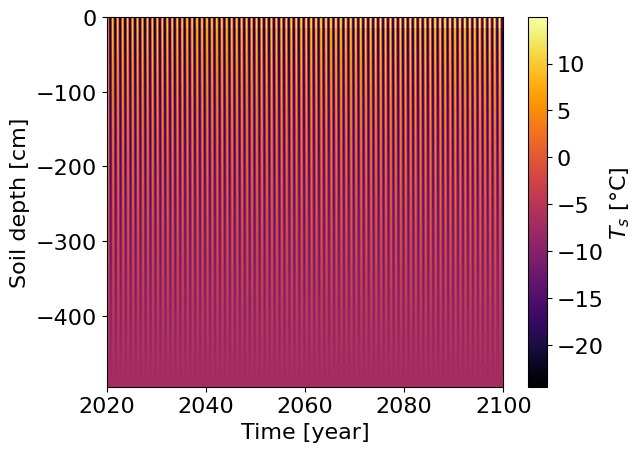

In [100]:
plt.rcParams.update({'font.size': 16})

tt,zz = np.meshgrid(t,z)
# Notice we're plotting -zz to have the top of the soil at the top and negative
# into the land surface
plt.pcolormesh(tt,-zz,Ts,cmap='inferno',shading='auto')
plt.colorbar(label='$T_s$ [°C]')
plt.xlabel('Time [year]')
plt.ylabel('Soil depth [cm]')

3. A markdown table showing the approximate depth of the active layer for each scenario for the first, a middle, and the final decade of the simulation.  

Unsure how to do the  markdown table in python. It is my understanding that we want to approximate the depth layer at the three different temperature scenarios for the first, middle and last decade. It could mean calculate for those numbers, or tell python to pull-in those number from the data.